## Summary

In this notebook, we test the accuracy of a network trained to solve Sudoku puzzles on the *validation dataset*, comprised of puzzles generated using the same `sugen` progam that was used to generate the training dataset, and on the *test dataset*, comprised of 30 Sudoku puzzles collected from http://1sudoku.com.

----

## Imports

In [1]:
import os
import sys
import tempfile
import time
from collections import deque
from pathlib import Path

import tqdm
from torch_geometric.data import DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow
import torch
import torch.nn as nn
from matplotlib import cm
from tensorflow.python.summary.summary_iterator import summary_iterator

In [2]:
import proteinsolver
import proteinsolver.datasets

/home/ubuntu/anaconda3/envs/defaults-v009/lib/python3.7/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)


In [3]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

## Parameters

In [4]:
UNIQUE_ID = "c8de7e56"

In [5]:
DATA_ROOT = Path(tempfile.gettempdir())
DATA_ROOT.mkdir(exist_ok=True)
DATA_ROOT

PosixPath('/tmp')

In [6]:
NOTEBOOK_NAME = "sudoku_analysis"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('sudoku_analysis')

In [7]:
DATAPKG_DATA_DIR = Path(f"~/datapkg_data_dir").expanduser().resolve()
DATAPKG_DATA_DIR

PosixPath('/data/datapkg_data_dir')

In [8]:
proteinsolver.settings.data_url = DATAPKG_DATA_DIR.as_posix()
proteinsolver.settings.data_url

'/data/datapkg_data_dir'

## Load data

In [9]:
datasets = {}

In [11]:
datasets["sudoku_valid_0"] = proteinsolver.datasets.SudokuDataset4(
    root=DATA_ROOT.joinpath("sudoku_valid_0"), subset=f"valid_0"
)

In [13]:
datasets["sudoku_test"] = proteinsolver.datasets.SudokuDataset2(
    root=DATA_ROOT.joinpath("sudoku_test"),
    data_url=DATAPKG_DATA_DIR.joinpath(
        "deep-protein-gen", "sudoku", "sudoku_test.csv.gz"
    ).as_posix(),
)

## Training plots

In [14]:
dfs = []

for tb_file in Path(f"sudoku_train/runs/{UNIQUE_ID}.xxx/").glob("*"):
    data = []
    for e in summary_iterator(tb_file.as_posix()):
        for v in e.summary.value:
            row = (e.step, v.tag, v.simple_value)
            data.append(row)
            if v.tag == "accuracy_mv":
                row = (e.step, "wall_time", e.wall_time)
                data.append(row)
    df = (
        pd.DataFrame(data, columns=["datapoint", "tag", "simple_value"])
        .pivot(index="datapoint", columns="tag", values="simple_value")
        .reset_index()
    )
    dfs.append(df)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [15]:
df = pd.concat(dfs, sort=False)
print(len(df))

95281


In [16]:
df = df.sort_values("wall_time", ascending=False).drop_duplicates(subset=["datapoint"], keep="first").sort_values("wall_time", ascending=True)
print(len(df))

92813


In [17]:
assert len(df) == len(df["datapoint"].drop_duplicates())

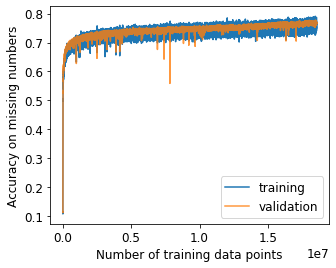

In [18]:
fg, ax = plt.subplots(figsize=(5, 4))
ax.plot(df["datapoint"], df["accuracy_m"], color=cm.get_cmap("tab10")(0), alpha=1, label="training")
ax.plot(df["datapoint"], df["accuracy_mv"], color=cm.get_cmap("tab10")(1), alpha=0.8, label="validation")
# ax.hlines(0.7, 0, df["datapoint"].max(), linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel("Number of training data points")
ax.set_ylabel("Accuracy on missing numbers")
ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
# ax.set_ylim(0, 0.82)
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-training-curve.svg")

## Load model

In [19]:
%run sudoku_train/{UNIQUE_ID}/model.py

<Figure size 432x288 with 0 Axes>

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [21]:
state_files = sorted(
    Path("sudoku_train").joinpath(UNIQUE_ID).glob("*.state"),
    key=lambda s: (int(s.stem.split("-")[3].strip("amv")), int(s.stem.split("-")[2].strip("d"))),
)

state_files[-5:]

[PosixPath('sudoku_train/c8de7e56/e1-s400000-d2400000-amv07269.state'),
 PosixPath('sudoku_train/c8de7e56/e1-s600000-d3600000-amv07396.state')]

In [22]:
state_file = state_files[-1]
state_file

PosixPath('sudoku_train/c8de7e56/e1-s400000-d2400000-amv07269.state')

In [23]:
net = Net(
    x_input_size=13, adj_input_size=3, hidden_size=162, output_size=9, batch_size=8
).to(device)

net.load_state_dict(torch.load(state_file, map_location=device))
net.eval()
net = net.to(device)

## Test plots

### Oneshot

In [24]:
edge_attr = next(iter(datasets["sudoku_valid_0"])).edge_attr.to(device)

In [25]:
results = []
for data in datasets["sudoku_test"]:
    data = data.to(device)
    is_missing = data.x == 9
    output = net(data.x, data.edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
oneshot_results_df = pd.DataFrame(results)

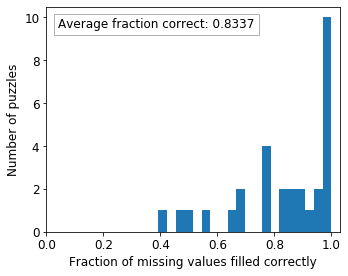

In [26]:
xlim = (0, 1.03)
textstr = """\
Average fraction correct: {:.4f}
""".format(
    (oneshot_results_df["num_correct"] / oneshot_results_df["num_total"]).mean()
).strip()
props = dict(facecolor="white", alpha=0.3)

fg, ax = plt.subplots(figsize=(5, 4))
data = oneshot_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=20)
ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Oneshot")
ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-test-oneshot.svg")

### Incremental

In [27]:
@torch.no_grad()
def design_sudoku(net, x, edge_index, edge_attr, log_conf_lst=None):
    mask = (x == 9)
    if not mask.any():
        return x
    
    index_array = torch.arange(x.size(0))
    
    output = net(x, edge_index, edge_attr)
    output = output[mask]
    index_array = index_array[mask]

    max_pred, max_index = torch.softmax(output, dim=1).max(dim=1)

    _, max_residue = max_pred.max(dim=0)
    if log_conf_lst is not None:
        log_conf_lst.append(torch.log(max_pred[max_residue]).data.cpu())

    assert x[index_array[max_residue]] == 9
    x[index_array[max_residue]] = max_index[max_residue]
    return design_sudoku(net, x, edge_index, edge_attr, log_conf_lst)

In [28]:
wrong_preds = []
results = []
for data in tqdm.tqdm_notebook(datasets["sudoku_test"], total=len(datasets["sudoku_test"])):
    data = data.to(device)
    x_in = data.x.clone()
    is_missing = x_in == 9
    log_conf_lst = []
    predicted = design_sudoku(net, x_in, data.edge_index, edge_attr, log_conf_lst)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append(
        {
            "fraction_correct": num_correct / num_total,
            "num_correct": num_correct,
            "num_total": num_total,
            "sum_log_prob": np.sum(log_conf_lst),
        }
    )
    if num_correct < num_total:
        wrong_preds.append(
            (
                data.x.data.cpu().numpy(),
                data.edge_index.data.cpu().numpy(),
                data.y.data.cpu().numpy(),
                predicted.data.cpu().numpy(),
            )
        )
results_df = pd.DataFrame(results)
print(results_df["num_correct"].sum() / results_df["num_total"].sum())

/home/ubuntu/anaconda3/envs/defaults-v009/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until



0.9744897959183674


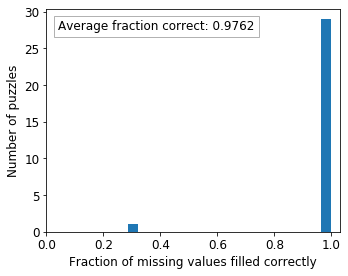

In [29]:
xlim = (0, 1.03)
textstr = """\
Average fraction correct: {:.4f}
""".format(
    (results_df["num_correct"] / results_df["num_total"]).mean()
).strip()
props = dict(facecolor="white", alpha=0.3)

fg, ax = plt.subplots(figsize=(5, 4))
data = results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=20)
ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
# ax.set_title("Test - Incremental")
ax.text(
    0.04,
    0.95,
    textstr,
    transform=ax.transAxes,
    fontsize="medium",
    verticalalignment="top",
    bbox=props,
)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-test-incremental.svg", bbox_inches="tight")

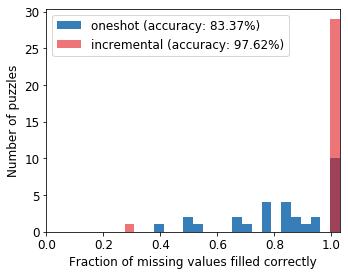

In [30]:
fraction_correct_oneshot = (oneshot_results_df["num_correct"] / oneshot_results_df["num_total"]).mean()
fraction_correct_incremental = (results_df["num_correct"] / results_df["num_total"]).mean()

fg, ax = plt.subplots(figsize=(5, 4))

data = oneshot_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=1, label=f"oneshot (accuracy: {fraction_correct_oneshot:.2%})", color=cm.get_cmap("Set1")(1))

data = results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=0.6, label=f"incremental (accuracy: {fraction_correct_incremental:.2%})", color=cm.get_cmap("Set1")(0))

ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
ax.legend(loc="upper left")
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-test-oneshot-incremental.svg", bbox_inches="tight")

## Validation plots

### Oneshot

In [31]:
results = []

for i, data in tqdm.tqdm_notebook(
    enumerate(
        DataLoader(
            datasets["sudoku_valid_0"],
            shuffle=False,
            num_workers=1,
            batch_size=1,
            drop_last=False,
        )
    ),
    total=1000,
):
    if i >= 1000:
        break
    data = data.to(device)
    is_missing = data.x == 9
    output = net(data.x, data.edge_index, data.edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append(
        {
            "fraction_correct": num_correct / num_total,
            "num_correct": num_correct,
            "num_total": num_total,
        }
    )
val_oneshot_results_df = pd.DataFrame(results)

/home/ubuntu/anaconda3/envs/defaults-v009/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


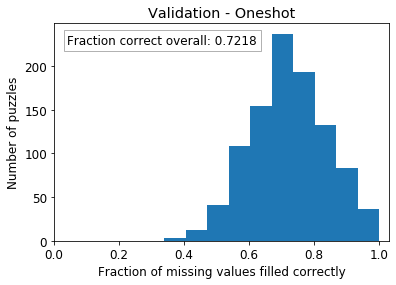

In [32]:
xlim = (0.0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    (val_oneshot_results_df["num_correct"] / val_oneshot_results_df["num_total"]).mean()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = val_oneshot_results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
    #     ax.set_ylim(0, 5)
    ax.set_title("Validation - Oneshot")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-validation-oneshot.svg")

### Incremental

In [33]:
@torch.no_grad()
def design_sudoku(net, x, edge_index, edge_attr):
    mask = (x == 9)
    if not mask.any():
        return x
    output = net(x, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    max_pred, max_index = output.max(dim=1)
    max_pred[~mask] = -1
    _, max_residue = max_pred.max(dim=0)
    x[max_residue] = max_index[max_residue]
    return design_sudoku(net, x, edge_index, edge_attr)

In [34]:
results = []

for i, data in tqdm.tqdm_notebook(
    enumerate(
        DataLoader(
            datasets["sudoku_valid_0"],
            shuffle=False,
            num_workers=1,
            batch_size=1,
            drop_last=False,
        )
    ),
    total=1000,
):
    if i >= 1000:
        break
    data = data.to(device)
    x_in = data.x.clone()
    is_missing = x_in == 9
    predicted = design_sudoku(net, x_in, data.edge_index, data.edge_attr)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
val_results_df = pd.DataFrame(results)

/home/ubuntu/anaconda3/envs/defaults-v009/lib/python3.7/site-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


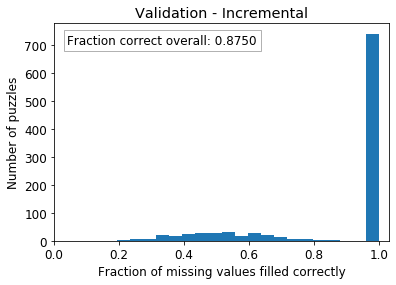

In [35]:
xlim = (0.0, 1.03)
textstr = """\
Fraction correct overall: {:.4f}
""".format(
    (val_results_df["num_correct"] / val_results_df["num_total"]).mean()
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4))
    data = val_results_df["fraction_correct"]
    assert data.min() >= xlim[0] and data.max() <= xlim[1]
    ax.hist(data, bins=20)
    ax.set_ylabel("Number of puzzles")
    ax.set_xlabel("Fraction of missing values filled correctly")
    ax.set_xlim(*xlim)
#     ax.set_ylim(0, 5)
    ax.set_title("Validation - Incremental")
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-validation-incremental.svg")

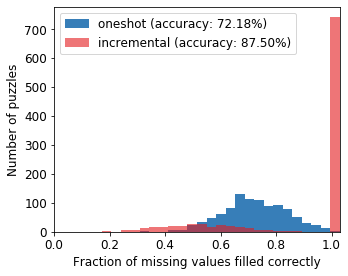

In [36]:
fraction_correct_oneshot = (val_oneshot_results_df["num_correct"] / val_oneshot_results_df["num_total"]).mean()
fraction_correct_incremental = (val_results_df["num_correct"] / val_results_df["num_total"]).mean()

fg, ax = plt.subplots(figsize=(5, 4))

data = val_oneshot_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=1, density=False, label=f"oneshot (accuracy: {fraction_correct_oneshot:.2%})", color=cm.get_cmap("Set1")(1))

data = val_results_df["fraction_correct"]
assert data.min() >= xlim[0] and data.max() <= xlim[1]
ax.hist(data, bins=30, range=xlim, alpha=0.6, density=False, label=f"incremental (accuracy: {fraction_correct_incremental:.2%})", color=cm.get_cmap("Set1")(0))

ax.set_ylabel("Number of puzzles")
ax.set_xlabel("Fraction of missing values filled correctly")
ax.set_xlim(*xlim)
ax.legend(loc="upper left")
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-validation-oneshot-incremental.svg", bbox_inches="tight")